# Deep neural network-based models for predicting mRNA editing in Trachurus trachurus
1 channel STR
Bidirectional LSTM with Attention Layer

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, precision_score, cohen_kappa_score, classification_report
import seaborn as sns; sns.set()
from keras import backend as K


In [2]:
########################################
# PARAMS
########################################
fname      = 'ttr_DL_Pad_W50_BALANCED_1_1_CODED1CH_STR.csv'
separator_char=';'
#categories=[['A','G','C','T'],['s','d','h','i','b']]
categories=[['s','d','h','i','b']]
padding=True
ptrain     = 0.7
trace_level = 1
model_name = 'TFM_LSTMBidiAttention_TT_1CH_STR'
num_lstm_units=256
n_epochs=40
batch_size=32
categories_size=5
random_seed=2022
########################################

We can run this notebook in two environments:
+ Googlr Colab Pro (Cloud)
+ Jupyter Lab (Locally)

In [3]:
#CHECK GOOGLE COLAB
GOOGLE_COLAB=False
if 'google.colab' in str(get_ipython()):
  GOOGLE_COLAB=True  
  print('Running on CoLab')
else:
  print('Not running on CoLab')

Running on CoLab


Checking if GPU is available and GPU characteristics.

In [4]:
#CHECK GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Num GPUs Available: {}'.format(len(tf.config.list_physical_devices('GPU'))))
  print('Found GPU at: {}'.format(device_name))
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
     print('Not connected to a GPU')
  else:
     print(gpu_info)

Num GPUs Available: 1
Found GPU at: /device:GPU:0
Tue Mar 21 08:31:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    28W /  70W |    339MiB / 15360MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                      

In [5]:
if padding==True:
    categories_size+=1

if GOOGLE_COLAB==False:
    data_dir = '../../data/datasets/ALL_TT/W50'
    models_dir = './SAVED_MODELS'

else:
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    #set the path to find RNAEd module
    sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks')    
    data_dir  = '/content/drive/MyDrive/DATASETS/ALL_TT/W50'
    models_dir= '/content/drive/MyDrive/MODELS'

Mounted at /content/drive


In [6]:
from RNAEd import DataGenerator,DataEncoding
encoder=DataEncoding(categories,padding=padding,pad_char="*")
n_ch,cat=encoder.getChannels()
print("Number of channels: {} /categories: {}".format(n_ch,cat))
encoder.print_LUT_TupleToInteger()
categories_size=encoder.getNumCodes()
print("Number of codes or categories size: {}".format(categories_size))

Number of channels: 1 /categories: [['s', 'd', 'h', 'i', 'b']]
Number of codes=6
('s',) / 0
('d',) / 1
('h',) / 2
('i',) / 3
('b',) / 4
('*',) / 5
Number of codes or categories size: 6


In [7]:
#We can save best model and last model
best_model = 'best_model_'+model_name+'.h5'
last_model =  model_name+'.h5'
lastmodelfile = os.path.join(models_dir, last_model)
print("LAST MODEL FILE: {}".format(lastmodelfile))
bestmodelfile = os.path.join(models_dir, best_model)
print("BEST MODEL FILE: {}".format(bestmodelfile))
datafile = os.path.join(data_dir, fname)    

LAST MODEL FILE: /content/drive/MyDrive/MODELS/TFM_LSTMBidiAttention_TT_1CH_STR.h5
BEST MODEL FILE: /content/drive/MyDrive/MODELS/best_model_TFM_LSTMBidiAttention_TT_1CH_STR.h5


We read the data.

In [8]:
print("DATASET: {}".format(datafile))
data = pd.read_csv(datafile,sep=separator_char)
print("shape dataraw={}".format(data.shape))

DATASET: /content/drive/MyDrive/DATASETS/ALL_TT/W50/ttr_DL_Pad_W50_BALANCED_1_1_CODED1CH_STR.csv
shape dataraw=(283012, 104)


In [9]:
print(data.head)

<bound method NDFrame.head of                                             GENE    POS  EDITING  P1  P2  P3  \
0        ENSTTAG00005005711_ENSTTAG00005005711_5   1228        0   0   0   0   
1       ENSTTAG00005017640_ENSTTAG00005017640_10     90        0   0   0   0   
2        ENSTTAG00005001674_ENSTTAG00005001674_3   8230        0   1   1   1   
3        ENSTTAG00005007503_ENSTTAG00005007503_8    103        0   0   0   0   
4        ENSTTAG00005012092_ENSTTAG00005012092_8  14793        0   2   2   2   
...                                          ...    ...      ...  ..  ..  ..   
283007  ENSTTAG00005007400_ENSTTAG00005007400_12    816        1   0   1   1   
283008   ENSTTAG00005009670_ENSTTAG00005009670_7   7042        1   1   1   1   
283009  ENSTTAG00005012170_ENSTTAG00005012170_14  23219        1   1   1   3   
283010   ENSTTAG00005011348_ENSTTAG00005011348_5   3951        1   1   1   1   
283011   ENSTTAG00005026230_ENSTTAG00005026230_1   6095        1   2   2   2   

        P

We will divide the data into: train, validation and test.
The three datastes should be well balanced.

In [10]:
# Train and Validation+Test
data_train, data_val_test, data_y_train, data_y_val_test = train_test_split(data, data['EDITING'], test_size=1-ptrain, random_state=random_seed)
#Validation and test: 0.5/0.5
data_val, data_test, data_y_val, data_y_test = train_test_split(data_val_test, data_y_val_test, test_size=0.5, random_state=random_seed)

print("data_train:{} data_y_train:{}".format(data_train.shape,data_y_train.shape))
print("data_val: {} data_y_val: {}".format(data_val.shape,data_y_val.shape))
print("data_test: {} data_y_test: {}".format(data_test.shape,data_y_test.shape))
print("TRAIN LABELS:")
print(data_y_train.value_counts())
print("VALIDATION LABELS:")
print(data_y_val.value_counts())
print("TEST LABELS:")
print(data_y_test.value_counts())

data_train:(198108, 104) data_y_train:(198108,)
data_val: (42452, 104) data_y_val: (42452,)
data_test: (42452, 104) data_y_test: (42452,)
TRAIN LABELS:
0    99090
1    99018
Name: EDITING, dtype: int64
VALIDATION LABELS:
0    21275
1    21177
Name: EDITING, dtype: int64
TEST LABELS:
1    21311
0    21141
Name: EDITING, dtype: int64


We instantiate 3 DataGenerator objects that convert from integer to one-hot

In [11]:
#DataGenerator converts on the fly from raw data to one-hot
num_nucleosides = data_train.iloc[:,3:].shape[1]
print("num_nucleosides={}".format(num_nucleosides))
print("categories_size={}".format(categories_size))
training_generator   = DataGenerator(data_train.iloc[:,3:], data_y_train, batch_size=batch_size, seq_size=num_nucleosides, categories_size=categories_size, shuffle=True)
validation_generator = DataGenerator(  data_val.iloc[:,3:], data_y_val,   batch_size=batch_size, seq_size=num_nucleosides, categories_size=categories_size, shuffle=True)
test_generator       = DataGenerator( data_test.iloc[:,3:], data_y_test,  batch_size=1,seq_size=num_nucleosides, categories_size=categories_size, shuffle=False )

num_nucleosides=101
categories_size=6


## Attention Layer

In [12]:
from keras.layers import *
from keras.models import *
from keras import backend as K

class attention(Layer):
    ''' heredamos de la clase layer '''
    def __init__(self):
        super(attention,self).__init__()
    
    #En el método build definimos los pesos
    def build(self, input_shape):
        # Define the shape of the weights and bias in this layer
        # The layer has just 1 lonely neuron
        
        # For convenience sake, add a couple of properties
        self.num_dim_pernucleoside = input_shape[-1] ## 512 dimension del vector de contexto.
        self.nucleosides_persequence = input_shape[-2]  ## 101 número de timesteps de la secuencia
        num_units = 1
        
        
        #Weights shape=(512,1), recordemos que la red neuronal capa oculta tiene un peso por dimensión.
        self.W=self.add_weight(name="att_weight", shape=(self.num_dim_pernucleoside,num_units),
                               initializer="normal")
        #bias  shape=(101,1), hay un bias por cada timestep, palabra o nucleótido.
        self.b=self.add_weight(name="att_bias", shape=(self.nucleosides_persequence,num_units),
                               initializer="zeros")
        super(attention,self).build(input_shape)
    
    #en el método call definimos la lógica
    #esta es la implementación clásica
    def call_classic(self, x):
        # x is the input tensor of 2 x num_units = 512 dimensions
        """ We multiply the inputs ‘x’ of shape (101,512) by the layer weights ‘w’ 
        of shape (512 , 1) and obtain a (101,1) values (future attention weights). We add the bias (101,1) 
        and pass the output through any activation layer to form a neural network. So we now have 101 * 1 values and 
        We take a softmax of these values. Softmax squashes these into values in the 
        range between 0, and 1 whose sum is 1. These are the 101 attention weights. 
        We multiply each attention weight by the respective nucleoside hidden state and sum up and we are done. 
        We now have the ‘attention adjusted output’ state ready to be fed to the next dense layer for classification."""
        
        #e = K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)  # Necesario en algunos frameworks
        e = K.tanh(K.dot(x,self.W)+self.b) #Red neuronal densa de una neurona con una matriz de pesos W y un vector de bias
        a = K.softmax(e, axis=1) #hacemos softmax para normalizar y que los pesos sumen 1.
        # Multiplicamos cada hidden state por cada peso (101,512)*(101,1)=(101,512). 
        # No es matricial, sino componente a componente 
        output = x*a 
        #Sumamos los 101 hidden states y se obtiene un hidden state suma de dimensión (101,512)
        #También se retornan los pesos a (101,1)
        return a, K.sum(output, axis=1)
  
    #esta implementación es más robusta
    def call(self, x):
        """ Es lo mismo de antes pero más robusto a distintos frameworks"""
        e = K.tanh(K.dot(x,self.W)+self.b) # dimensiones (101,512)(512,1)+(101,1)=(101,1)
        e = Flatten()(e) #(?,101)
        a = Activation('softmax')(e) #(?,101)
        # Repite 512 veces los 101 pesos (?,101) = (?,512,101)
        temp = RepeatVector(self.num_dim_pernucleoside)(a)
        #Permuta (?,512,101) por (?,101,512) para poder multiplicar componente a 
        #componente después
        temp = Permute([2,1])(temp) 
        # Multiplicamnos por cada peso todas las componentes de todos los hidden states
        # hidden state X=(101,512) pesos=temp=(101,512)
        # el truco aquí es que cada fila de pesos es una repetición de 512 pesos iguales.
        output = Multiply()([x,temp])
        #Finalmente sumamos todas las filas y obtenemos así el hidden state ponderado
        output = Lambda(lambda values: K.sum(values, axis=1))(output)
        #Retornamos los pesos de atención y la suma de los hidden states.
        return a, output

## Model defined from the scratch

In [13]:
#MODELOS REDES NEURONALES LSTM CON CAPAS DE ATENCIÓN
# Import the libraries required in this example:

num_tokens = categories_size
print("Number of units={}".format(num_lstm_units))
#Definimos la estructura con el Functional model
inputs = keras.Input(shape=(num_nucleosides,num_tokens), name="INPUTS")
lstm_out   = layers.Bidirectional(layers.LSTM(num_lstm_units,return_sequences=True), name="LSTM_BI")(inputs)
dropout= layers.Dropout(0.2)(lstm_out)

#===============================
#METHOD 1: using a custom layer:
#===============================
#La salida de la capa bidireccional será de 1 batch=None numero de secuencias, 
#de 101 nucleosidos(timesteps=50+1+50) de 2 x número_unidades=2*256=512
#Es decir (None,101,512)
#---------uncomment here--------------------
#a ,att_d = attention()(dropout)
#-----------------------------
#La capa de atención debe retornarnos un peso para cada hidden state 
#correspondiente a cada elemento de la secuencia o timestep
#es decir, nos debe dar un peso por cada nucleósido, es decir, nos debe dar (101,1)
#Como son pesos probabilisticos deben sumar 1.
#Pero realmente no queremos esos pesos, sino la suma de los 101 hidden states 
#de dimensión 512 ponderados por esos pesos que es lo que conforma el verdadero contexto, 
# y que tendrá dimensión (None,1,512).
#Esta salida es lo que se llama el "attention adjusted output state".
#Para ello, nuestra capa de atención debe entrenar (101,1) pesos, ya que debemos 
#entrenar un peso por cada dimensión del espacio vectorial del contexto.
#Pero ojo, esos no son los pesos de la red neuronal de la capa de atención, porque si nuestra
#red neuronal de atención tuviera 101 pesos, serían posicionales y deben ser calculados por el 
#valor semántico de los nucleótidos (si fueran palabras por su significado, no por su posición)

#Nuestra red neuronal de atención debe atender al "significado" de las palabras, es decir,
#a la codificación de cada nucleótido en el vector de estados 
#de la LSTM que tiene dimensión 512. Por lo tanto el número de pesos de la  red de atención 
# es de (512,1). Son los pesos de las 512 conexiones de la neurona de esta capa.

#Durante el entrenamiento multiplicaremos matricialmente todos los nucleótidos de la 
#secuencia (101), con su codificación LSTMbidi(512), por los pesos de la capa de atención(512) y eso 
#nos dará los 101 pesos de atención:
#(101,512) x (512,1) = (101,1) los pesos de atención
#(512,1) son los pesos de la capa.

#Ahora entendemos por qué los pesos de atención no son constantes
#sino que para cada secuencia cambian:
#En una red ya entrenada:
#  (101,512)[variable] x (512,1)[constante] = (101,1)[variable]

#===============================================================

#===============================
#METHOD 2: using regular layers:
#===============================

#---------uncomment here--------------------
e=Dense(1, activation='tanh')(dropout) #Capa de atención
e=Flatten()(e)
a=Activation('softmax')(e) #Softmax para que sumen 1 los pesos de atención.
temp=RepeatVector(2*num_lstm_units)(a)
temp=Permute([2, 1])(temp)
# multiply weight with LSTM layer o/p
output = Multiply()([dropout, temp])
# Get the attention adjusted output state by adding up
att = Lambda(lambda values: K.sum(values, axis=1))(output)
#-----------------------------

#===============================================================
outputs= layers.Dense(1, activation='sigmoid', name="OUTPUT")(att)
#Creamos el modelo
model_from_scratch  = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

#Mostramos el modelo
print(model_from_scratch.summary())

Number of units=256
Model: "TFM_LSTMBidiAttention_TT_1CH_STR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 INPUTS (InputLayer)            [(None, 101, 6)]     0           []                               
                                                                                                  
 LSTM_BI (Bidirectional)        (None, 101, 512)     538624      ['INPUTS[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 101, 512)     0           ['LSTM_BI[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 101, 1)       513         ['dropout[0][0]']                
                                               

In [14]:
#Compilation reset all weights
model_from_scratch.compile(optimizer=keras.optimizers.Adam(),
                           loss     =keras.losses.BinaryCrossentropy(),
                           metrics  =[keras.metrics.BinaryAccuracy()])

model=model_from_scratch

Recover last model, best model or generate a new model

In [15]:
#Load the trained model from disk
import os.path

best_model_accuracy =0
last_model_accuracy =0


In [16]:
if os.path.exists(bestmodelfile):
    model = tf.keras.models.load_model(bestmodelfile)
    print("Testing best model file: {}".format(bestmodelfile))
    results = model.evaluate(validation_generator,verbose=1)
    best_model_accuracy = results[1]
    print("best model accuracy: {}".format(best_model_accuracy))    

In [17]:
if os.path.exists(lastmodelfile):
    model = tf.keras.models.load_model(lastmodelfile)
    print("Testing last complete model file: {}".format(lastmodelfile))
    results = model.evaluate(validation_generator,verbose=1)
    last_model_accuracy = results[1]
    print("last model accuracy: {}".format(last_model_accuracy))           


In [18]:
if best_model_accuracy >= last_model_accuracy and best_model_accuracy != 0:
   model = tf.keras.models.load_model(bestmodelfile)
   print("Selected best model saved: {}".format(bestmodelfile))
else:
  if last_model_accuracy > best_model_accuracy:
     print("Selected last model saved: {}".format(lastmodelfile))
  else:
     print("Selected new untrained model")


# Show the model architecture
model.summary()

Selected new untrained model
Model: "TFM_LSTMBidiAttention_TT_1CH_STR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 INPUTS (InputLayer)            [(None, 101, 6)]     0           []                               
                                                                                                  
 LSTM_BI (Bidirectional)        (None, 101, 512)     538624      ['INPUTS[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 101, 512)     0           ['LSTM_BI[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 101, 1)       513         ['dropout[0][0]']                
                                      

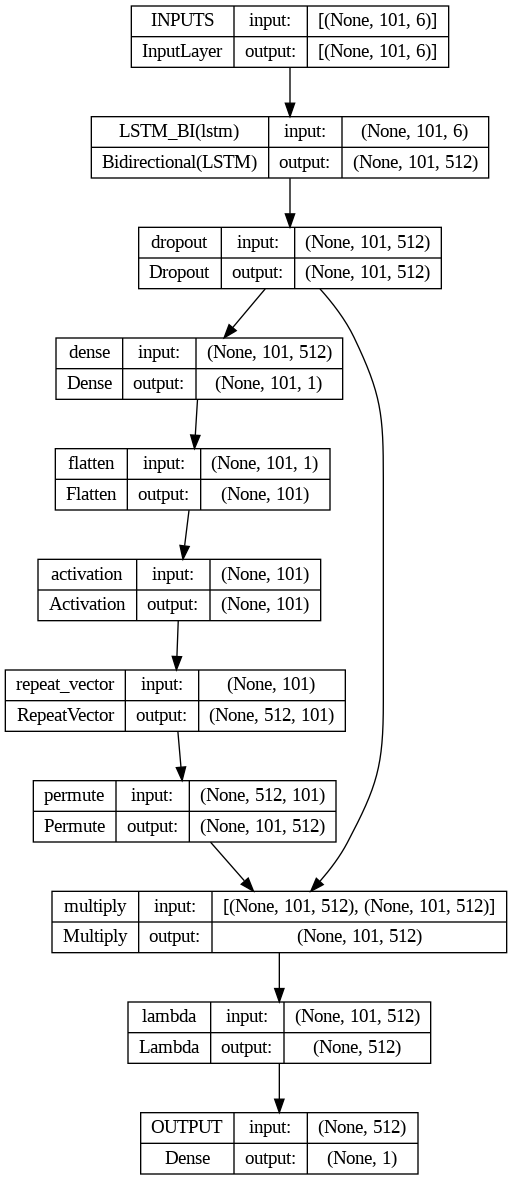

In [19]:
keras.utils.plot_model(model, show_shapes=True)

In [20]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpoint = ModelCheckpoint(bestmodelfile, 
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='auto', 
                             save_freq='epoch')

callback=EarlyStopping(monitor='val_loss', 
                       min_delta=0, 
                       patience=3, 
                       verbose=1, 
                       mode='auto',
                       baseline=None, 
                       restore_best_weights=True)

In [21]:
with tf.device(device_name):#Use GPU if available
    history=model.fit(training_generator,epochs=n_epochs,
                      validation_data=validation_generator,
                      callbacks=[checkpoint,callback],verbose=trace_level)

Epoch 1/40
6190/6190 [==============================] - ETA: 0s - loss: 0.6905 - binary_accuracy: 0.5283
Epoch 1: val_loss improved from inf to 0.69073, saving model to /content/drive/MyDrive/MODELS/best_model_TFM_LSTMBidiAttention_TT_1CH_STR.h5
6190/6190 [==============================] - 1161s 186ms/step - loss: 0.6905 - binary_accuracy: 0.5283 - val_loss: 0.6907 - val_binary_accuracy: 0.5195
Epoch 2/40
6190/6190 [==============================] - ETA: 0s - loss: 0.6900 - binary_accuracy: 0.5344
Epoch 2: val_loss improved from 0.69073 to 0.69021, saving model to /content/drive/MyDrive/MODELS/best_model_TFM_LSTMBidiAttention_TT_1CH_STR.h5
6190/6190 [==============================] - 1133s 183ms/step - loss: 0.6900 - binary_accuracy: 0.5344 - val_loss: 0.6902 - val_binary_accuracy: 0.5283
Epoch 3/40
6190/6190 [==============================] - ETA: 0s - loss: 0.6899 - binary_accuracy: 0.5357
Epoch 3: val_loss improved from 0.69021 to 0.68678, saving model to /content/drive/MyDrive/MODE

In [22]:
#We always save the last model.
#Last model can be triggered by early stopping
n_epochs_trained = len(history.history['loss'])
print("Trained epochs: {} of {}".format(n_epochs_trained,n_epochs))
model.save(lastmodelfile)    

Trained epochs: 10 of 40


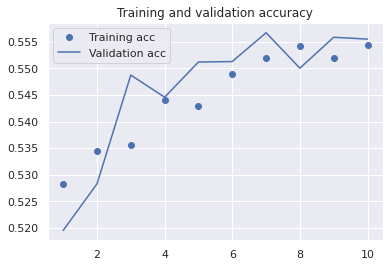

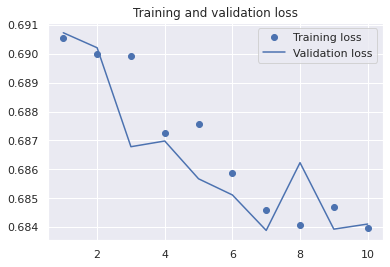

In [23]:
#PLOT ACCURACY AND LOSS

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

We recover the best model saved.

In [24]:
if os.path.exists(bestmodelfile):
    model = tf.keras.models.load_model(bestmodelfile)

We evaluate the best model on validation data.

In [25]:
#EVALUATE VALIDATION DATASET
print("Evaluate models on validation data")
results_model = model.evaluate(validation_generator,verbose=trace_level)
print ('Accuracy on validation data:',round(results_model[1],3))
print ('Loss on validation data:',round(results_model[0],3))

Evaluate models on validation data
1326/1326 [==============================] - 192s 144ms/step - loss: 0.6839 - binary_accuracy: 0.5567
Accuracy on validation data: 0.557
Loss on validation data: 0.684


We make predictions on test data, never used during training nor validation

In [26]:
#PREDICTIONS
print("Make predictions on test data")
model_prediction = model.predict(test_generator,verbose=trace_level)
model_prediction_binary = (model_prediction > 0.5).astype("int32")

Make predictions on test data
42452/42452 [==============================] - 353s 8ms/step


In [27]:
print(data_test.shape)
print(data_y_test.shape)
print(model_prediction.shape)
print(model_prediction_binary.shape)

(42452, 104)
(42452,)
(42452, 1)
(42452, 1)


In [28]:
#METRICS QUALITY CLASSIFICATION
print("MODEL "+model_name+"\n---------------------------------")
kappa = cohen_kappa_score(data_y_test, model_prediction_binary)
print ('Kappa:',round(kappa,3))
print(classification_report(data_y_test, model_prediction_binary))

MODEL TFM_LSTMBidiAttention_TT_1CH_STR
---------------------------------
Kappa: 0.11
              precision    recall  f1-score   support

           0       0.56      0.48      0.52     21141
           1       0.55      0.63      0.59     21311

    accuracy                           0.56     42452
   macro avg       0.56      0.55      0.55     42452
weighted avg       0.56      0.56      0.55     42452



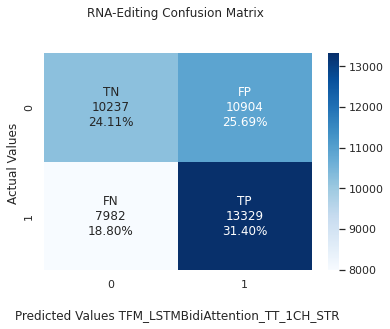

In [29]:
from sklearn.metrics import confusion_matrix, precision_score, cohen_kappa_score, classification_report
import seaborn as sns; sns.set()
# PLOT CONFUSION MATRIX
# Tutorial: https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/
plt.figure()

cm = confusion_matrix(data_y_test,model_prediction_binary)

group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('RNA-Editing Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values '+ model_name)
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
#ax.xaxis.set_ticklabels(['False','True'])
#ax.yaxis.set_ticklabels(['False','True'])
plt.show()


AUC: 0.58


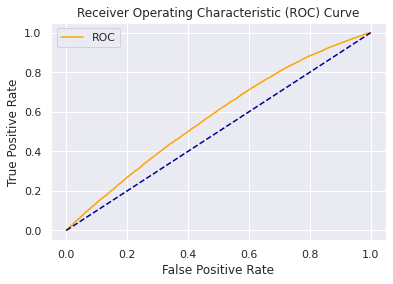

In [30]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color="orange", label="ROC")
    plt.plot([0, 1], [0, 1], color="darkblue", linestyle="--")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

auc = roc_auc_score(data_y_test, model_prediction)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(data_y_test, model_prediction)
plot_roc_curve(fpr, tpr)

# RESULTS INSIGHT

In [31]:
results_data = data_test
if 'RESULT_TYPE' not in results_data.columns:
    #insert column at position 3
    results_data.insert(3,"RESULT_TYPE", None)
    results_data.insert(4,"PROB_PRED",model_prediction)
else:
    print("RESULT_TYPE already exists in the dataframe")

results_data.head()

,GENE,POS,EDITING,RESULT_TYPE,PROB_PRED,P1,P2,P3,P4,P5,...,P92,P93,P94,P95,P96,P97,P98,P99,P100,P101
266365,ENSTTAG00005013451_ENSTTAG00005013451_8,7064,1,None,0.569653,2,2,2,2,2,...,1,1,1,1,3,1,1,1,1,3
165318,ENSTTAG00005017913_ENSTTAG00005017913_22,16376,0,None,0.461390,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1
48269,ENSTTAG00005002915_ENSTTAG00005002915_7,19118,0,None,0.561629,1,3,1,1,1,...,2,2,2,2,2,2,2,1,1,1
89431,ENSTTAG00005015315_ENSTTAG00005015315_17,2354,0,None,0.547285,1,1,1,1,2,...,1,1,1,1,1,1,1,1,0,0
4298,ENSTTAG00005021524_ENSTTAG00005021524_15,3110,0,None,0.601795,1,1,1,1,1,...,1,1,1,1,1,1,1,3,3,3


In [32]:
column_index=results_data.columns.get_loc('RESULT_TYPE')
i=0
for result in model_prediction_binary:
    #print("Comparing result={} with data_y_test={}".format(result[0],data_y_test.iloc[i]))
    if   result[0]==0 and data_y_test.iloc[i]==0:
       typeRes ="TN"
    elif result[0]==0 and data_y_test.iloc[i]==1:
       typeRes="FN"
    elif result[0]==1 and data_y_test.iloc[i]==0:
       typeRes="FP"
    elif result[0]==1 and data_y_test.iloc[i]==1:
       typeRes="TP"
    results_data.iloc[i, column_index]=typeRes
    i+=1
    
results_data.head()

,GENE,POS,EDITING,RESULT_TYPE,PROB_PRED,P1,P2,P3,P4,P5,...,P92,P93,P94,P95,P96,P97,P98,P99,P100,P101
266365,ENSTTAG00005013451_ENSTTAG00005013451_8,7064,1,TP,0.569653,2,2,2,2,2,...,1,1,1,1,3,1,1,1,1,3
165318,ENSTTAG00005017913_ENSTTAG00005017913_22,16376,0,TN,0.461390,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1
48269,ENSTTAG00005002915_ENSTTAG00005002915_7,19118,0,FP,0.561629,1,3,1,1,1,...,2,2,2,2,2,2,2,1,1,1
89431,ENSTTAG00005015315_ENSTTAG00005015315_17,2354,0,FP,0.547285,1,1,1,1,2,...,1,1,1,1,1,1,1,1,0,0
4298,ENSTTAG00005021524_ENSTTAG00005021524_15,3110,0,FP,0.601795,1,1,1,1,1,...,1,1,1,1,1,1,1,3,3,3


In [33]:
#Save the results into a file
report_dir="/content/drive/MyDrive/REPORT"
results_csv_file  =model_name + "_Results.csv"
results_excel_file=model_name + "_Results.xlsx"
results_data.to_csv(os.path.join(report_dir,results_csv_file))
results_data.to_excel(os.path.join(report_dir,results_excel_file))

Now, we are going to find the record with highest probability and category TP (True Positive) as a good model of TP data,
and alternatively, the best representative of TN, using the lowest value

In [34]:
subset_TP=results_data.loc[results_data['RESULT_TYPE'] == 'TP']
prototype_of_TP_id=subset_TP['PROB_PRED'].idxmax()
print("rowid best TP = {}".format(prototype_of_TP_id))
print(results_data.loc[prototype_of_TP_id,])

rowid best TP = 239121
GENE           ENSTTAG00005020255_ENSTTAG00005020255_21
POS                                                5653
EDITING                                               1
RESULT_TYPE                                          TP
PROB_PRED                                      0.673141
                                 ...                   
P97                                                   1
P98                                                   1
P99                                                   1
P100                                                  3
P101                                                  1
Name: 239121, Length: 106, dtype: object


In [35]:
subset_TN=results_data.loc[results_data['RESULT_TYPE'] == 'TN']
prototype_of_TN_id=subset_TN['PROB_PRED'].idxmin()
print("rowid best TN = {}".format(prototype_of_TN_id))
print(results_data.loc[prototype_of_TN_id,])

rowid best TN = 83123
GENE           ENSTTAG00005013291_ENSTTAG00005013291_23
POS                                               11258
EDITING                                               0
RESULT_TYPE                                          TN
PROB_PRED                                      0.203803
                                 ...                   
P97                                                   5
P98                                                   5
P99                                                   5
P100                                                  5
P101                                                  5
Name: 83123, Length: 106, dtype: object
